In [1]:
# Install MediaPipe for face detection
!pip install mediapipe

INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Successfully uninstalled opencv-contrib-python-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bi

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

from tensorflow.keras.layers import (
    Dense, Input, Layer, GlobalAveragePooling1D, LayerNormalization, 
    Lambda, Dropout, Reshape, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ============================================================
# 1. CUSTOM LAYERS (Preserved from your working version)
# ============================================================

class MultiHeadAttention(Layer):
    """Custom MHA for compatibility with older TF versions."""
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.d_model = num_heads * key_dim
        
        self.query_dense = Dense(self.d_model)
        self.key_dense = Dense(self.d_model)
        self.value_dense = Dense(self.d_model)
        self.combine_heads = Dense(self.d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, value, key):
        batch_size = tf.shape(query)[0]
        
        # Linear projections
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        
        # Reshape and combine heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        
        return self.combine_heads(output)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config
        
class VisionTemporalTransformer(Layer):
    def __init__(self, patch_size=8, d_model=128, num_heads=4, spatial_layers=1, temporal_layers=1, **kwargs):
        super(VisionTemporalTransformer, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.spatial_layers = spatial_layers
        self.temporal_layers = temporal_layers

        self.dense_projection = Dense(d_model)
        self.pos_emb = None

        self.spatial_mhas = [MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(spatial_layers)]
        self.spatial_norm1 = [LayerNormalization() for _ in range(spatial_layers)]
        self.spatial_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(spatial_layers)]
        self.spatial_norm2 = [LayerNormalization() for _ in range(spatial_layers)]

        self.temporal_mhas = [MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads) for _ in range(temporal_layers)]
        self.temporal_norm1 = [LayerNormalization() for _ in range(temporal_layers)]
        self.temporal_ffn = [tf.keras.Sequential([Dense(d_model*4, activation='relu'), Dense(d_model)]) for _ in range(temporal_layers)]
        self.temporal_norm2 = [LayerNormalization() for _ in range(temporal_layers)]
        
    def build(self, input_shape):
        H = input_shape[2]
        W = input_shape[3]
        ph = H // self.patch_size
        pw = W // self.patch_size
        num_patches = ph * pw
        self.pos_emb = self.add_weight(shape=(1, num_patches, self.d_model), initializer='random_normal', trainable=True, name='pos_emb')
        super(VisionTemporalTransformer, self).build(input_shape)

    def call(self, inputs):
        # 1. Handle Shapes
        input_shape = inputs.get_shape() 
        shape = tf.shape(inputs)
        
        batch = shape[0]
        frames = shape[1]
        H = shape[2]
        W = shape[3]
        
        # Attempt to get static Channel dim
        C_static = input_shape[-1]
        C = C_static if C_static is not None else shape[4]

        # 2. Reshape
        reshaped = tf.reshape(inputs, (-1, H, W, C))

        # 3. Extract Patches
        patches = tf.image.extract_patches(
            images=reshaped,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        
        # 4. Flatten Patches & FORCE SHAPE
        if C_static is not None:
            patch_dim_static = self.patch_size * self.patch_size * C_static
        else:
            patch_dim_static = None
            
        patch_dim_dynamic = tf.shape(patches)[-1]
        final_patch_dim = patch_dim_static if patch_dim_static is not None else patch_dim_dynamic
        
        patches = tf.reshape(patches, (-1, tf.shape(patches)[1] * tf.shape(patches)[2], final_patch_dim))

        if patch_dim_static is not None:
             patches.set_shape([None, None, patch_dim_static])

        # 5. Projection
        x = self.dense_projection(patches) + self.pos_emb

        # 6. Spatial Transformer
        for i in range(self.spatial_layers):
            attn = self.spatial_mhas[i](x, value=x, key=x)
            x = self.spatial_norm1[i](x + attn)
            ff = self.spatial_ffn[i](x)
            x = self.spatial_norm2[i](x + ff)

        # 7. Temporal Pooling
        x = tf.reshape(x, (batch, frames, -1, self.d_model))
        x = tf.reduce_mean(x, axis=2)  

        # FORCE STATIC SHAPE FOR TEMPORAL (Required for older TF)
        x.set_shape([None, None, self.d_model]) 

        # 8. Temporal Transformer
        for i in range(self.temporal_layers):
            attn = self.temporal_mhas[i](x, value=x, key=x)
            x = self.temporal_norm1[i](x + attn)
            ff = self.temporal_ffn[i](x)
            x = self.temporal_norm2[i](x + ff)

        pooled = GlobalAveragePooling1D()(x)
        return pooled

    def get_config(self):
        config = super(VisionTemporalTransformer, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "spatial_layers": self.spatial_layers,
            "temporal_layers": self.temporal_layers,
        })
        return config

# ============================================================
# 2. MODEL DEFINITION
# ============================================================

def batch_consistency_loss(y_true, features):
    f = tf.reshape(features, (tf.shape(features)[0], -1))
    f_norm = tf.math.l2_normalize(f, axis=1)
    sim_matrix = tf.matmul(f_norm, f_norm, transpose_b=True)
    avg_sim = tf.reduce_mean(sim_matrix, axis=1)
    return 1.0 - avg_sim

def consistency_loss_wrapper(y_true, y_pred):
    return batch_consistency_loss(y_true, y_pred)

def build_lipinc_model(frame_shape=(8,64,144,3), residue_shape=(7,64,144,3), d_model=128):
    frame_input = Input(shape=frame_shape, name='FrameInput')
    residue_input = Input(shape=residue_shape, name='ResidueInput')

    vt = VisionTemporalTransformer(
        patch_size=8, d_model=d_model, num_heads=4, spatial_layers=1, temporal_layers=1
    )

    frame_feat = vt(frame_input)      
    residue_feat = vt(residue_input) 

    expand1 = Lambda(lambda x: tf.expand_dims(x, axis=1))
    q = expand1(frame_feat)
    k = expand1(residue_feat)
    v = k

    mha = MultiHeadAttention(num_heads=4, key_dim=d_model//4)
    attn_out = mha(q, value=v, key=k)  

    squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))
    attn_out = squeeze(attn_out)

    concat = Lambda(lambda t: tf.concat(t, axis=1))
    fusion = concat([frame_feat, residue_feat, attn_out])

    x = Dense(512, activation='relu')(fusion)
    x = Dense(256, activation='relu')(x)

    class_output = Dense(2, activation='softmax', name='class_output')(x)
    features_output = Dense(d_model, activation=None, name='features_output')(x)

    model = Model(
        inputs=[frame_input, residue_input],
        outputs=[class_output, features_output],
        name='LIPINC_fixed'
    )
    return model

print("Model architecture loaded.")

2025-11-29 16:32:59.008730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764433979.199864      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764433979.253779      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model architecture loaded.


In [3]:
import cv2
import numpy as np
import mediapipe as mp

class MouthExtractor:
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        # ref: https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/face_mesh.py
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True, # Improves lip accuracy
            min_detection_confidence=0.5
        )
        print("✅ MediaPipe FaceMesh Loaded (No Dlib required!)")

        # MediaPipe Indices for Lips (Outer and Inner)
        # We use these to calculate the bounding box
        self.Mouth_Indices = [
            61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, # Upper Lip
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291    # Lower Lip
        ]
        
        # Indices for calculating openness (Upper Inner vs Lower Inner)
        self.upper_inner = 13
        self.lower_inner = 14
        self.mouth_left = 61
        self.mouth_right = 291

    def get_mouth_openness(self, landmarks, img_w, img_h):
        # Convert normalized coordinates to pixels
        u = landmarks[self.upper_inner]
        l = landmarks[self.lower_inner]
        left = landmarks[self.mouth_left]
        right = landmarks[self.mouth_right]

        # Calculate height and width
        height = np.linalg.norm(np.array([u.x * img_w, u.y * img_h]) - np.array([l.x * img_w, l.y * img_h]))
        width = np.linalg.norm(np.array([left.x * img_w, left.y * img_h]) - np.array([right.x * img_w, right.y * img_h]))

        return height / (width + 1e-6)

    def crop_mouth(self, img, landmarks):
        h, w, _ = img.shape
        
        # Get all mouth landmark coordinates
        mouth_points = []
        for idx in self.Mouth_Indices:
            pt = landmarks[idx]
            mouth_points.append([int(pt.x * w), int(pt.y * h)])
        
        mouth_points = np.array(mouth_points)
        
        # Bounding Box
        x, y, mw, mh = cv2.boundingRect(mouth_points)
        
        # Add Padding (20% width, 50% height)
        pad_w = int(mw * 0.2)
        pad_h = int(mh * 0.5)
        
        x1 = max(0, x - pad_w)
        y1 = max(0, y - pad_h)
        x2 = min(w, x + mw + pad_w)
        y2 = min(h, y + mh + pad_h)
        
        crop = img[y1:y2, x1:x2]
        
        # Resize to (144, 64) -> CV2 expects (W, H)
        resized = cv2.resize(crop, (144, 64))
        return resized

    def process_video(self, video_path, frame_count=8, scan_limit=60):
        cap = cv2.VideoCapture(video_path)
        frames_buffer = []
        openness_scores = []
        crops_buffer = []
        
        count = 0
        while True:
            ret, frame = cap.read()
            if not ret or count >= scan_limit:
                break
            
            # Convert BGR to RGB for MediaPipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.face_mesh.process(rgb_frame)
            
            if results.multi_face_landmarks:
                landmarks = results.multi_face_landmarks[0].landmark
                h, w, _ = frame.shape
                
                score = self.get_mouth_openness(landmarks, w, h)
                crop = self.crop_mouth(frame, landmarks)
                
                openness_scores.append((count, score))
                crops_buffer.append(crop)
                frames_buffer.append(frame) # Keep track of valid frames
            
            count += 1
        cap.release()

        # Fallback if no faces found
        if len(crops_buffer) < frame_count:
            return self._fallback_processing(frames_buffer if frames_buffer else [np.zeros((64,144,3), dtype=np.uint8)], frame_count)

        # Selection Logic: Prioritize High Openness
        openness_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Pick indices evenly spaced from the valid detections
        indices = np.linspace(0, len(crops_buffer)-1, frame_count, dtype=int)
        
        # Or, if you want strictly the most open mouths, use the top N scores
        # But for video consistency, temporal spacing is usually better.
        final_crops = [crops_buffer[i] for i in indices]
        
        return np.array(final_crops) / 255.0

    def _fallback_processing(self, frames, target_count):
        processed = []
        # If we have frames but no face, just resize the whole center
        for i in range(target_count):
            if i < len(frames):
                resized = cv2.resize(frames[i], (144, 64))
                processed.append(resized)
            else:
                processed.append(np.zeros((64, 144, 3)))
        return np.array(processed) / 255.0

# Initialize global extractor
mouth_extractor = MouthExtractor()

✅ MediaPipe FaceMesh Loaded (No Dlib required!)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=16, frame_count=8, dim=(64, 144), shuffle=True, **kwargs):
        # FIX 1: Pass kwargs to super for multiprocessing support
        super().__init__(**kwargs)
        
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_paths = [self.video_paths[k] for k in indexes]
        list_labels = [self.labels[k] for k in indexes]
        return self.__data_generation(list_paths, list_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def compute_residue(self, frames):
        # Section C: Delta Frames (Dt = Rt+1 - Rt)
        residues = np.zeros((self.frame_count - 1, self.dim[0], self.dim[1], 3), dtype=np.float32)
        for i in range(1, len(frames)):
            residues[i-1] = frames[i] - frames[i-1]
        return residues

    def __data_generation(self, list_paths, list_labels):
        X_frames = np.empty((self.batch_size, self.frame_count, *self.dim, 3))
        X_residues = np.empty((self.batch_size, self.frame_count-1, *self.dim, 3))
        y = np.empty((self.batch_size, 2), dtype=int)
        
        # Dummy features target for the consistency loss
        dummy_feats = np.zeros((self.batch_size, 128))

        for i, path in enumerate(list_paths):
            # USE MOUTH EXTRACTOR (Assumes mouth_extractor is defined globally)
            frames = mouth_extractor.process_video(path, frame_count=self.frame_count)
            
            # Ensure shape consistency
            if frames.shape != (self.frame_count, self.dim[0], self.dim[1], 3):
                # Emergency pad/resize if something went wrong
                if len(frames) > 0:
                    frames = cv2.resize(frames[0], (self.dim[1], self.dim[0]))
                    frames = np.array([frames] * self.frame_count)
                else:
                    frames = np.zeros((self.frame_count, self.dim[0], self.dim[1], 3))

            X_frames[i,] = frames
            X_residues[i,] = self.compute_residue(frames)
            y[i] = list_labels[i]

        # FIX 2: Return Dictionaries instead of Lists
        # Matches Input Layer names: 'FrameInput', 'ResidueInput'
        X = {
            'FrameInput': X_frames,
            'ResidueInput': X_residues
        }
        
        # Matches Output Layer names
        targets = {
            'class_output': y, 
            'features_output': dummy_feats
        }

        return X, targets

W0000 00:00:1764433994.547994      72 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764433994.575164      75 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
import pandas as pd
import json
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------
# 1. SETUP PATHS (FaceForensics++ Only)
# -----------------------------------------------------------
FF_REAL_PATH = "/kaggle/input/ff-c23/FaceForensics++_C23/original"

# List of all Fake sub-datasets in FaceForensics++
FF_FAKE_PATHS = [
    "/kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes",
    "/kaggle/input/ff-c23/FaceForensics++_C23/Face2Face",
    "/kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap",
    "/kaggle/input/ff-c23/FaceForensics++_C23/NeuralTextures"
]

# -----------------------------------------------------------
# 2. LOAD REAL VIDEOS
# -----------------------------------------------------------
print("Scanning FaceForensics++ Real Videos...")
ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.mp4'), recursive=True)

# Fallback for .avi if .mp4 is empty (Dataset specific check)
if not ff_real: 
    ff_real = glob(os.path.join(FF_REAL_PATH, '**', '*.avi'), recursive=True)

print(f"Real Videos found: {len(ff_real)}")

# -----------------------------------------------------------
# 3. LOAD FAKE VIDEOS (Aggregating all 4 types)
# -----------------------------------------------------------
print("\nScanning FaceForensics++ Fake Videos (Deepfakes, F2F, FaceSwap, NeuralTextures)...")
ff_fake = []

for fake_path in FF_FAKE_PATHS:
    # Recursively find videos in each sub-folder
    videos = glob(os.path.join(fake_path, '**', '*.mp4'), recursive=True)
    if not videos:
        videos = glob(os.path.join(fake_path, '**', '*.avi'), recursive=True)
    
    print(f" - Found {len(videos)} in {os.path.basename(fake_path)}")
    ff_fake.extend(videos)

print(f"Total Fake Videos found: {len(ff_fake)}")

# -----------------------------------------------------------
# 4. BALANCE DATA (Random Undersampling)
# -----------------------------------------------------------
print("\n--- Balancing Data ---")

# Convert to numpy array for easier indexing
ff_fake = np.array(ff_fake)
ff_real = np.array(ff_real)

n_real = len(ff_real)
n_fake = len(ff_fake)

print(f"Counts -> Real: {n_real}, Fake: {n_fake}")

if n_fake > n_real:
    print(f"Undersampling Fake videos from {n_fake} to {n_real}...")
    # Randomly choose 'n_real' indices from fake paths without replacement
    ff_fake_balanced = np.random.choice(ff_fake, n_real, replace=False)
else:
    print("Fake videos are fewer or equal to Real. No undersampling needed.")
    ff_fake_balanced = ff_fake

# Final Lists used for training
final_real_paths = ff_real
final_fake_paths = ff_fake_balanced

# Create Labels: [1, 0] for Real, [0, 1] for Fake
final_real_labels = [[1, 0]] * len(final_real_paths)
final_fake_labels = [[0, 1]] * len(final_fake_paths)

# Merge into single dataset
all_paths = np.concatenate([final_real_paths, final_fake_paths])
all_labels = np.concatenate([final_real_labels, final_fake_labels])

print(f"Final Balanced Dataset: {len(all_paths)} total videos ({len(final_real_paths)} Real, {len(final_fake_paths)} Fake)")

# -----------------------------------------------------------
# 5. SPLIT DATA
# -----------------------------------------------------------
# Stratified split to maintain class balance in Train/Val/Test
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTraining on: {len(X_train_paths)}")
print(f"Validation on: {len(X_val_paths)}")
print(f"Testing on: {len(X_test_paths)}")

# -----------------------------------------------------------
# 6. INSTANTIATE GENERATORS
# -----------------------------------------------------------
BATCH_SIZE = 16

train_gen = VideoDataGenerator(X_train_paths, y_train, batch_size=BATCH_SIZE)
val_gen = VideoDataGenerator(X_val_paths, y_val, batch_size=BATCH_SIZE)
test_gen = VideoDataGenerator(X_test_paths, y_test, batch_size=BATCH_SIZE, shuffle=False)

Scanning FaceForensics++ Real Videos...
Real Videos found: 1000

Scanning FaceForensics++ Fake Videos (Deepfakes, F2F, FaceSwap, NeuralTextures)...
 - Found 1000 in Deepfakes
 - Found 1000 in Face2Face
 - Found 1000 in FaceSwap
 - Found 1000 in NeuralTextures
Total Fake Videos found: 4000

--- Balancing Data ---
Counts -> Real: 1000, Fake: 4000
Undersampling Fake videos from 4000 to 1000...
Final Balanced Dataset: 2000 total videos (1000 Real, 1000 Fake)

Training on: 1400
Validation on: 300
Testing on: 300


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# -----------------------------------------------------------
# 1. BUILD & COMPILE
# -----------------------------------------------------------
model = build_lipinc_model()
model.summary()

opt = Adam(learning_rate=1e-4)

model.compile(
    optimizer=opt,
    loss={
        # Naming these keys exactly creates the "class_output_loss" log output
        'class_output': 'categorical_crossentropy', 
        'features_output': consistency_loss_wrapper 
    },
    loss_weights={
        'class_output': 1.0, 
        'features_output': 5.0 
    },
    metrics={'class_output': 'accuracy'}
)

# -----------------------------------------------------------
# 2. DEFINE CALLBACKS
# -----------------------------------------------------------
checkpoint = ModelCheckpoint(
    'best_lipinc_model.h5', 
    monitor='val_class_output_accuracy', 
    save_best_only=True, 
    mode='max',
    verbose=1  # <--- CRITICAL: This enables the "Epoch 01: saving model..." printout
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    restore_best_weights=True,
    verbose=1
)

# -----------------------------------------------------------
# 3. TRAIN
# -----------------------------------------------------------
print("Starting Training on Full Dataset...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, early_stop],
    verbose=1  # <--- CRITICAL: This enables the progress bar and metric logs
)

# Save the final state
model.save('lipinc_full_data_final.h5')
print("Model saved.")

I0000 00:00:1764434005.228003      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "LIPINC_fixed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ FrameInput          │ (None, 8, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResidueInput        │ (None, 7, 64,     │          0 │ -                 │
│ (InputLayer)        │ 144, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_temporal_tr… │ (None, 128)       │    439,680 │ FrameInput[0][0], │
│ (VisionTemporalTra… │                   │            │ ResidueInput[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 128)    │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │     66,048 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[1][0],     │
│                     │                   │            │ lambda[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 384)       │          0 │ vision_temporal_… │
│                     │                   │            │ vision_temporal_… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    197,120 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    131,328 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 2)         │        514 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_output     │ (None, 128)       │     32,896 │ dense_18[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 867,586 (3.31 MB)

 Trainable params: 867,586 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

Starting Training on Full Dataset...


W0000 00:00:1764434007.098503      74 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Epoch 1/50


I0000 00:00:1764434057.450570      87 service.cc:148] XLA service 0x798534fefcd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764434057.451334      87 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764434059.575658      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/87 ━━━━━━━━━━━━━━━━━━━━ 53:26 37s/step - class_output_accuracy: 0.3750 - class_output_loss: 1.0517 - features_output_loss: 0.0475 - loss: 1.2892

I0000 00:00:1764434069.224359      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - class_output_accuracy: 0.5013 - class_output_loss: 0.7280 - features_output_loss: 0.0080 - loss: 0.7682 
Epoch 1: val_class_output_accuracy improved from -inf to 0.52431, saving model to best_lipinc_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 1434s 16s/step - class_output_accuracy: 0.5017 - class_output_loss: 0.7277 - features_output_loss: 0.0080 - loss: 0.7676 - val_class_output_accuracy: 0.5243 - val_class_output_loss: 0.6839 - val_features_output_loss: 9.7353e-04 - val_loss: 0.6887
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - class_output_accuracy: 0.5593 - class_output_loss: 0.6814 - features_output_loss: 0.0010 - loss: 0.6865 
Epoch 2: val_class_output_accuracy did not improve from 0.52431
87/87 ━━━━━━━━━━━━━━━━━━━━ 1342s 15s/step - class_output_accuracy: 0.5593 - class_output_loss: 0.6815 - features_output_loss: 0.0010 - loss: 0.6866 - val_class_output_accuracy: 0.5000 - val_class_output_loss: 0.7637 - val_features_output_loss: 8.0251e-04 - val_loss: 0.7677
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - class_output_accuracy: 0.5904 - class_output_loss: 0.6822 - features_output_loss: 7.8726e-04 - loss: 0.6861 
Epoch 3: val_class_output_accuracy improved from 0.52431 to 0.57292, s

87/87 ━━━━━━━━━━━━━━━━━━━━ 1349s 16s/step - class_output_accuracy: 0.5905 - class_output_loss: 0.6820 - features_output_loss: 7.8728e-04 - loss: 0.6860 - val_class_output_accuracy: 0.5729 - val_class_output_loss: 0.6845 - val_features_output_loss: 7.2947e-04 - val_loss: 0.6881
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - class_output_accuracy: 0.5696 - class_output_loss: 0.6925 - features_output_loss: 6.7964e-04 - loss: 0.6959 
Epoch 4: val_class_output_accuracy did not improve from 0.57292
87/87 ━━━━━━━━━━━━━━━━━━━━ 1367s 16s/step - class_output_accuracy: 0.5698 - class_output_loss: 0.6923 - features_output_loss: 6.7904e-04 - loss: 0.6957 - val_class_output_accuracy: 0.5625 - val_class_output_loss: 0.6654 - val_features_output_loss: 6.3229e-04 - val_loss: 0.6686
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - class_output_accuracy: 0.6161 - class_output_loss: 0.6402 - features_output_loss: 6.3982e-04 - loss: 0.6434 
Epoch 5: val_class_output_accuracy did not improve from 0.

87/87 ━━━━━━━━━━━━━━━━━━━━ 1327s 15s/step - class_output_accuracy: 0.6264 - class_output_loss: 0.6444 - features_output_loss: 3.2904e-04 - loss: 0.6460 - val_class_output_accuracy: 0.6076 - val_class_output_loss: 0.6442 - val_features_output_loss: 4.9735e-04 - val_loss: 0.6467
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - class_output_accuracy: 0.6126 - class_output_loss: 0.6400 - features_output_loss: 3.4527e-04 - loss: 0.6417 
Epoch 8: val_class_output_accuracy did not improve from 0.60764
87/87 ━━━━━━━━━━━━━━━━━━━━ 1301s 15s/step - class_output_accuracy: 0.6127 - class_output_loss: 0.6399 - features_output_loss: 3.4469e-04 - loss: 0.6416 - val_class_output_accuracy: 0.5625 - val_class_output_loss: 0.6661 - val_features_output_loss: 2.7328e-04 - val_loss: 0.6675
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - class_output_accuracy: 0.6206 - class_output_loss: 0.6618 - features_output_loss: 2.7674e-04 - loss: 0.6632 
Epoch 9: val_class_output_accuracy improved from 0.60764 t

87/87 ━━━━━━━━━━━━━━━━━━━━ 1314s 15s/step - class_output_accuracy: 0.6208 - class_output_loss: 0.6616 - features_output_loss: 2.7698e-04 - loss: 0.6629 - val_class_output_accuracy: 0.6215 - val_class_output_loss: 0.6410 - val_features_output_loss: 2.2784e-04 - val_loss: 0.6421
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - class_output_accuracy: 0.6811 - class_output_loss: 0.6083 - features_output_loss: 3.1037e-04 - loss: 0.6098 
Epoch 10: val_class_output_accuracy improved from 0.62153 to 0.65972, saving model to best_lipinc_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 1296s 15s/step - class_output_accuracy: 0.6807 - class_output_loss: 0.6084 - features_output_loss: 3.1018e-04 - loss: 0.6100 - val_class_output_accuracy: 0.6597 - val_class_output_loss: 0.6312 - val_features_output_loss: 2.6488e-04 - val_loss: 0.6325
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - class_output_accuracy: 0.6565 - class_output_loss: 0.6114 - features_output_loss: 2.5418e-04 - loss: 0.6127 
Epoch 11: val_class_output_accuracy did not improve from 0.65972
87/87 ━━━━━━━━━━━━━━━━━━━━ 1278s 15s/step - class_output_accuracy: 0.6563 - class_output_loss: 0.6116 - features_output_loss: 2.5400e-04 - loss: 0.6129 - val_class_output_accuracy: 0.6181 - val_class_output_loss: 0.6368 - val_features_output_loss: 2.0171e-04 - val_loss: 0.6378
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - class_output_accuracy: 0.6405 - class_output_loss: 0.6280 - features_output_loss: 2.6114e-04 - loss: 0.6293 
Epoch 12: val_class_output_accuracy did not improve fro

Model saved.


In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score, jaccard_score, accuracy_score

print("\nEvaluating on Test Set...")
# 1. Standard Keras Evaluate (Loss & Accuracy)
results = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[-1]:.4f}")

# 2. Detailed Metrics Calculation
print("Calculating AP, AUC, and IoU...")
y_true_all = []
y_pred_all = []

# Reset generator to ensure we start from the beginning
test_gen.on_epoch_end()

# Loop through the generator to gather all predictions
for i in range(len(test_gen)):
    inputs, targets = test_gen[i]
    
    # Extract True Labels (One-hot encoded)
    y_true_batch = targets['class_output']
    
    # Get Predictions
    preds = model.predict_on_batch(inputs)
    # preds is a list [class_output, features_output], we need class_output (index 0)
    y_pred_batch = preds[0] 
    
    y_true_all.extend(y_true_batch)
    y_pred_all.extend(y_pred_batch)

# Convert to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Extract probabilities for the "Fake" class (Index 1)
# y_true_all is shape (N, 2) -> [Real, Fake]
# y_pred_all is shape (N, 2) -> [Prob_Real, Prob_Fake]
true_labels = y_true_all[:, 1]
pred_probs = y_pred_all[:, 1]

# Convert probabilities to hard binary labels (0 or 1) for IoU calculation
# Threshold is usually 0.5
pred_labels = (pred_probs > 0.5).astype(int)

try:
    # 1. ROC-AUC
    roc_auc = roc_auc_score(true_labels, pred_probs)
    
    # 2. Average Precision (AP)
    ap_score = average_precision_score(true_labels, pred_probs)
    
    # 3. Intersection over Union (IoU) - Equivalent to Jaccard Score for binary classification
    # Calculates: TP / (TP + FP + FN)
    iou_score = jaccard_score(true_labels, pred_labels, average='binary')

    print("-" * 30)
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print(f"AP Score : {ap_score:.4f}")
    print(f"IoU Score: {iou_score:.4f}")
    print("-" * 30)
    
except Exception as e:
    print("Error calculating metrics (Check if test set has both classes):", e)


Evaluating on Test Set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 233s 13s/step - class_output_accuracy: 0.6367 - class_output_loss: 0.6606 - features_output_loss: 1.9048e-04 - loss: 0.6615
Test Loss: 0.6484
Test Accuracy: 0.6250
Calculating AP, AUC, and IoU...
------------------------------
ROC-AUC  : 0.6866
AP Score : 0.6917
IoU Score: 0.4225
------------------------------


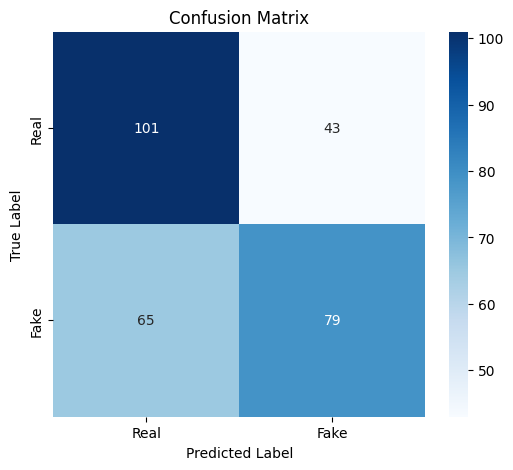


--- Classification Report ---
              precision    recall  f1-score   support

        Real       0.61      0.70      0.65       144
        Fake       0.65      0.55      0.59       144

    accuracy                           0.62       288
   macro avg       0.63      0.62      0.62       288
weighted avg       0.63      0.62      0.62       288



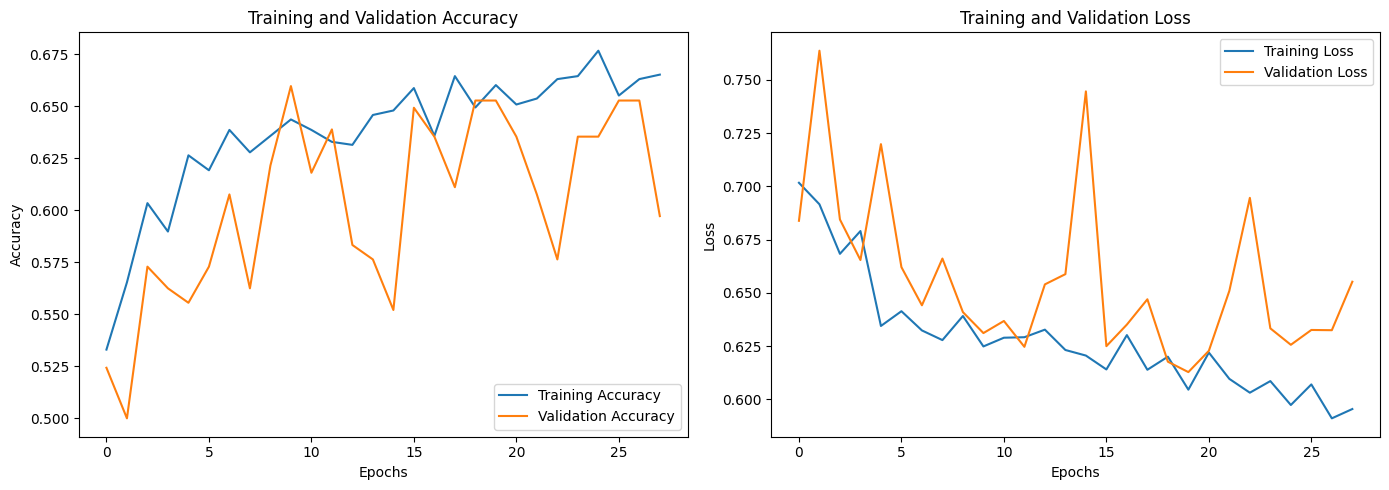

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================
# 1. Confusion Matrix & Classification Report
# ==========================================

# Ensure variables from the previous cell are available
# true_labels: 1D array of actual class indices (0 or 1)
# pred_labels: 1D array of predicted class indices (0 or 1)

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
print("\n--- Classification Report ---")
print(classification_report(true_labels, pred_labels, target_names=['Real', 'Fake']))

# ==========================================
# 2. Training History Plots
# ==========================================

# We plot the specific loss and accuracy for the 'class_output' head
acc = history.history['class_output_accuracy']
val_acc = history.history['val_class_output_accuracy']

loss = history.history['class_output_loss']
val_loss = history.history['val_class_output_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()